Muammar Yusuf Fakhri

# PREPARATION 

In [1]:
#we will use the train dataset for this work
#upload dataset
from google.colab import files
files.upload()


Saving train.csv to train.csv


{'train.csv': b'customer_id,Name,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score\nfffe4300490044003600300030003800,Pattie Morrisey,18,F,XW0DQ7H,Village,Platinum Membership,2017-08-17,No,xxxxxxxx,Gift Vouchers/Coupons,?,Wi-Fi,16:08:02,17,300.63,53005.25,17.0,781.75,Yes,Yes,No,Not Applicable,Products always in Stock,2\nfffe43004900440032003100300035003700,Traci Peery,32,F,5K0N3X1,City,Premium Membership,2017-08-28,?,CID21329,Gift Vouchers/Coupons,Desktop,Mobile_Data,12:38:13,16,306.34,12838.38,10.0,,Yes,No,Yes,Solved,Quality Customer Care,1\nfffe4300490044003100390032003600,Merideth Mcmeen,44,F,1F2TCL3,Town,No Membership,2016-11-11,Yes,CID12313,Gift 

In [3]:
#Data sciene Libraries
import pandas as pd
import numpy as np
#statistic
import statistics as sts
from scipy import stats
#visual
import matplotlib.pyplot as plt
import seaborn as sns
#scaler
from sklearn.preprocessing import StandardScaler , MinMaxScaler, RobustScaler,normalize
#imbalance
from imblearn.over_sampling import SMOTE
#spilting
from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict

import warnings
warnings.filterwarnings('ignore')

#model
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

#metric evaluation
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report

In [4]:
train = pd.read_csv('train.csv')
train.head(2)

customer_id  ... churn_risk_score
0      fffe4300490044003600300030003800  ...                2
1  fffe43004900440032003100300035003700  ...                1

[2 rows x 25 columns]

In [5]:
#replace ?,unknown and error value with missing value(np.nan)
train.replace(to_replace=['Unknown','?',-999],value=np.nan,inplace=True)

#we ignore churn value of -1 because it will make bias prediction
df = train[train['churn_risk_score']!=-1]

#avg_frequency_login_days to float
df['avg_frequency_login_days']=pd.to_numeric(df['avg_frequency_login_days'],errors='coerce')

#joining_date to datetime 
df['joining_date']=pd.to_datetime(df['joining_date'],format='%Y-%m-%d')

#drop unique fitur      
df.drop(labels=['customer_id','Name','security_no','last_visit_time'],axis=1,inplace=True)

df.head(2)

age gender  ...                  feedback churn_risk_score
0  18.0      F  ...  Products always in Stock              2.0
1  32.0      F  ...     Quality Customer Care              1.0

[2 rows x 21 columns]

In [6]:
df['feedback'].unique()

array(['Products always in Stock', 'Quality Customer Care',
       'Poor Website', 'No reason specified', 'Poor Product Quality',
       'Poor Customer Service', 'Too many ads', 'User Friendly Website',
       'Reasonable Price'], dtype=object)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35829 entries, 0 to 36991
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   age                           35829 non-null  float64       
 1   gender                        35773 non-null  object        
 2   region_category               30566 non-null  object        
 3   membership_category           35829 non-null  object        
 4   joining_date                  35829 non-null  datetime64[ns]
 5   joined_through_referral       30537 non-null  object        
 6   referral_id                   35829 non-null  object        
 7   preferred_offer_types         35553 non-null  object        
 8   medium_of_operation           30599 non-null  object        
 9   internet_option               35829 non-null  object        
 10  days_since_last_login         33885 non-null  float64       
 11  avg_time_spent              

We have 21 features in the dataframe and 1 target, namely the churn risk score.we will classify features based on their data type

In [8]:
num=[]
cat=[]
datetime=[]

for i in df.columns:
    if i =='churn_risk_score':
        cat.append(i)
    else:
        if df[i].dtypes =='object':
            cat.append(i)
        elif df[i].dtypes =='float64' or df[i].dtypes =='int64' :
            num.append(i)
        else :
            datetime.append(i)
            
print(f"variabel numeric : {num}")
print(f"variabel categoric : {cat}")
print(f"variabel datetime : {datetime}")

variabel numeric : ['age', 'days_since_last_login', 'avg_time_spent', 'avg_transaction_value', 'avg_frequency_login_days', 'points_in_wallet']
variabel categoric : ['gender', 'region_category', 'membership_category', 'joined_through_referral', 'referral_id', 'preferred_offer_types', 'medium_of_operation', 'internet_option', 'used_special_discount', 'offer_application_preference', 'past_complaint', 'complaint_status', 'feedback', 'churn_risk_score']
variabel datetime : ['joining_date']


# EDA

In [9]:
#this is a class to do EDA
class statplot:
    def __init__(self,kolom):
        self.kolom=kolom
    
    def stat(self):
        i=self.kolom
        if i =='churn_risk_score' :
            persen=df[i].value_counts(normalize=True)
            print(i)
            print(persen)
        
        else :
            if i in num:   #mean,median, mode , std,q1,q3,batas atas batas bawah for numeric variabel
                listMean=[]
                listMedian=[]
                listMode=[]
                listStd=[]
                listq1=[]
                listq3=[]
                listlb=[]
                listub=[]
                mean=round(np.mean(df[i]),2)
                median=round(df[i].median(),2)
                mode=df[i].mode()[0]
                std=round(df[i].std(),2)
                q1=round(df[i].quantile(0.25),2)
                q3=round(df[i].quantile(0.75),2)
                iqr=q3-q1
                lb=q1-1.5*iqr
                ub=q3+1.5*iqr

                listMean.append(mean)
                listMedian.append(median)
                listMode.append(mode)
                listStd.append(std)
                listq1.append(q1)
                listq3.append(q3)
                listlb.append(lb)
                listub.append(ub)

                numStat=pd.DataFrame({'mean':listMean,
                                      'median':listMedian,
                                      'mode':listMode, 
                                      'stdev':listStd,
                                      'q1':listq1,
                                      'q3':listq3,
                                      'lowerBound':listlb,
                                      'upperBound':listub},index=[i])
        
                return numStat

            elif i in cat:                                           #%proporsi  for  categotical variabel 
                persen=df[i].value_counts(normalize=True)
                print(i)
                print(persen)
    
    def plot(self):
        i=self.kolom
        if i =='churn_risk_score' :
            plot=sns.countplot(x=i, data=df)
            
            for bar in plot.patches:
                value = bar.get_height()
                persentase=round((value/df[i].count())*100,2)

                text=f"{persentase}({value})"
                textX=bar.get_x()+ bar.get_width()/2
                textY=bar.get_y() + value

                plot.text(textX, textY, text, ha='center', va='bottom', color='b', size=12)

        else :
            if i in num:   #kde plot for numeric variabel
                sns.distplot(df[i])

            elif i in cat:                                           #categotical variabel 
                plot=sns.countplot(x=i, data=df)
                for bar in plot.patches:
                    value = bar.get_height()
                    persentase=round((value/df[i].count())*100,2)

                    text=f"{persentase}%({value})"
                    textX=bar.get_x()+ bar.get_width()/2
                    textY=bar.get_y() + value

                    plot.text(textX, textY, text, ha='center', va='bottom', color='b', size=12)

In [10]:
#change i for statistic description feature
i='age'
variabel=statplot(i)
variabel.stat()

mean  median  mode  stdev    q1    q3  lowerBound  upperBound
age  37.12    37.0  33.0  15.87  23.0  51.0       -19.0        93.0

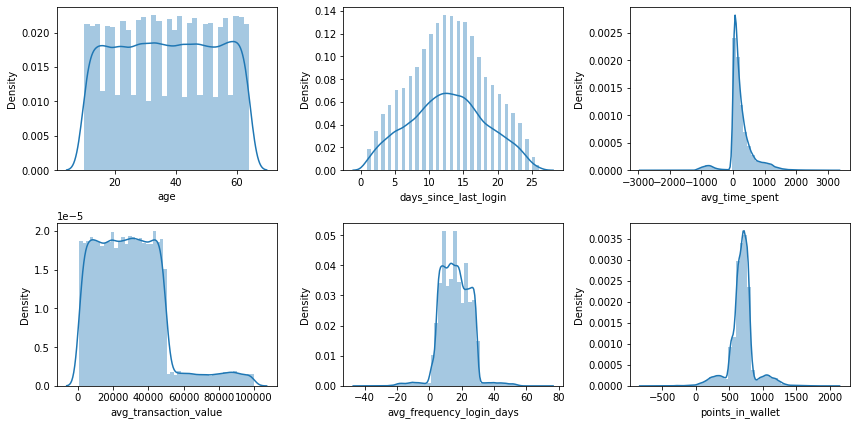

In [11]:
a=1
plt.figure(figsize=(12,6))
for i in num:
    variabel=statplot(i)
    plt.subplot(2,3,a)
    variabel.plot()
    a+=1
plt.tight_layout()

from the graph we conclude that dataset aren't normally distributed

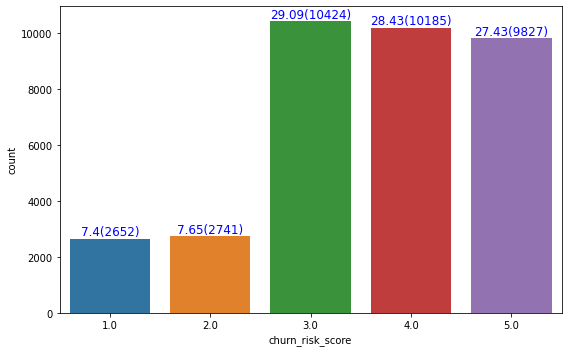

In [12]:
variabel=statplot('churn_risk_score') 
plt.figure(figsize=(8,5))
variabel.plot()
plt.tight_layout()

* bar chart shows that the ratio of high churn rates (3, 4, 5) is more compare with low churn rates (1,2)
* This shows that many customers are dissatisfied with the product or service. This has a bad impact on the Business.
* What makes Churn rate high?

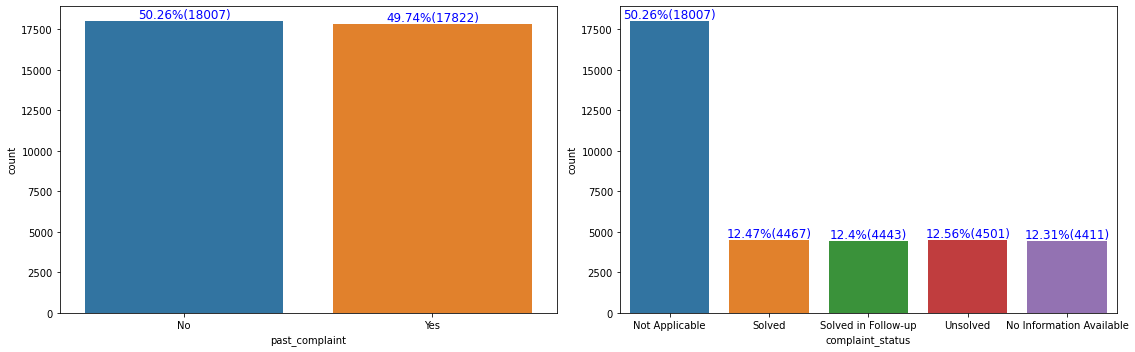

In [13]:
a=1
plt.figure(figsize=(16,5))
for i in ['past_complaint','complaint_status']:
  variabel=statplot(i) 
  plt.subplot(1,2,a)
  variabel.plot()
  a+=1
plt.tight_layout()

* Looking at the past_complain feature, the difference between those who complain and don't complain is 0.52%. A good business should have a bigger comparison difference, of course with a smaller proportion of customers who complain.

* Looking in more detail in the complaint_status feature, there are still complaints that are ignored, judging from the proportion of no information available at 12.31%, remember that customers left because they felt that they were not cared for by the business, one of the causes of the high churn rate.

* No in past_complaint feature and Not applicable in complaint_status feature has same value. Yes in past_complaint Feature is sum of solved,solved in follow-up, unsolved, and no information available in complaint_status feature.Complaint_status is detailed information from past_complaint. We will drop one of these features, because it has the same information.

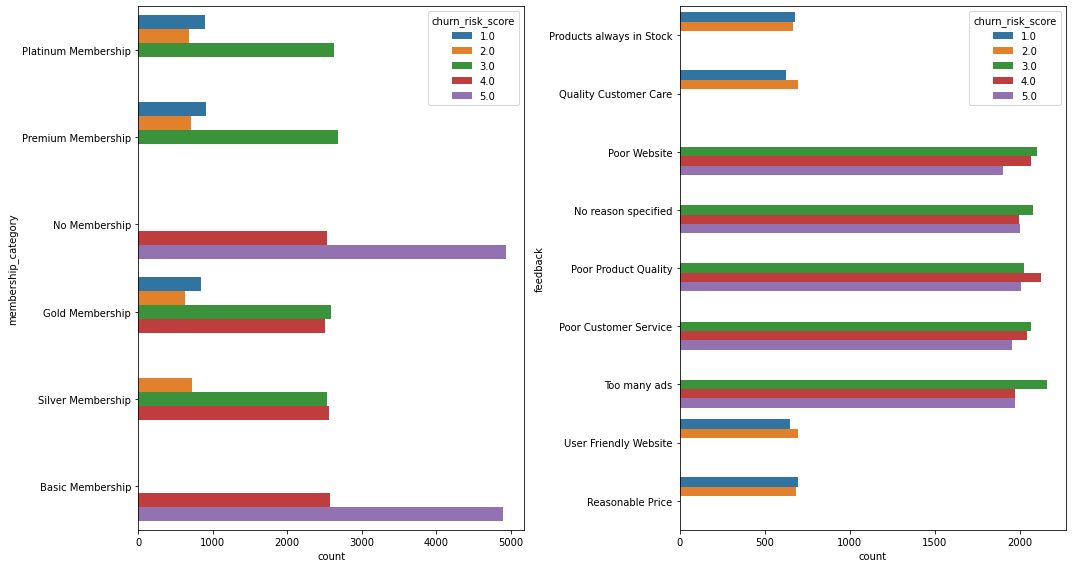

In [14]:
a=1
plt.figure(figsize=(15,8))
for i in ['membership_category','feedback']:
    plt.subplot(1,2,a)
    sns.countplot(y=i,hue='churn_risk_score',data=df)
    a+=1
plt.tight_layout()

* Order membership_category from lowest to highest
1. No Membership
2. Basic Membership
3. Silver Membership
4. Gold Membership
5. Premium Membership
6. Platinum Membership

* Bar chart shows that higher membership, higher churn rate is decreasing and the lower churn rate is increasing.This means that business services are getting lower for customers with low membership categories(no membership and basic membership)

* The bar chart shows that For customers with churn risk 1 and 2 provide positive feedback:
1. Products always in Stock
2. Quality Customer Care
3. Use Friendly Website
4. Reasonable Price
* Meanwhile, customers with churn risk 3,4 and 5 gave negative feedback:
1. Poor Website
2. Poor Product Quality
3. Poor Customer Service
4. Too many ads

* No Reason spesific its neutral feedback

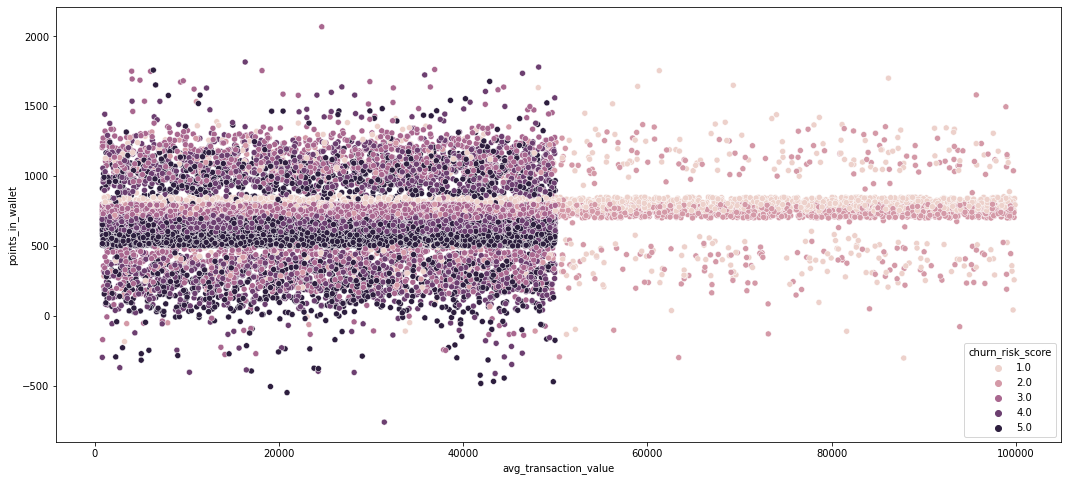

In [15]:
plt.figure(figsize=(18,8))
sns.scatterplot(x='avg_transaction_value',y='points_in_wallet',hue='churn_risk_score', data=df)
plt.show()

* The scatterplot shows that the distribution of customers who have made transactions of more than 50000 have a low churn rate (1 and 2)

# Preprocessing

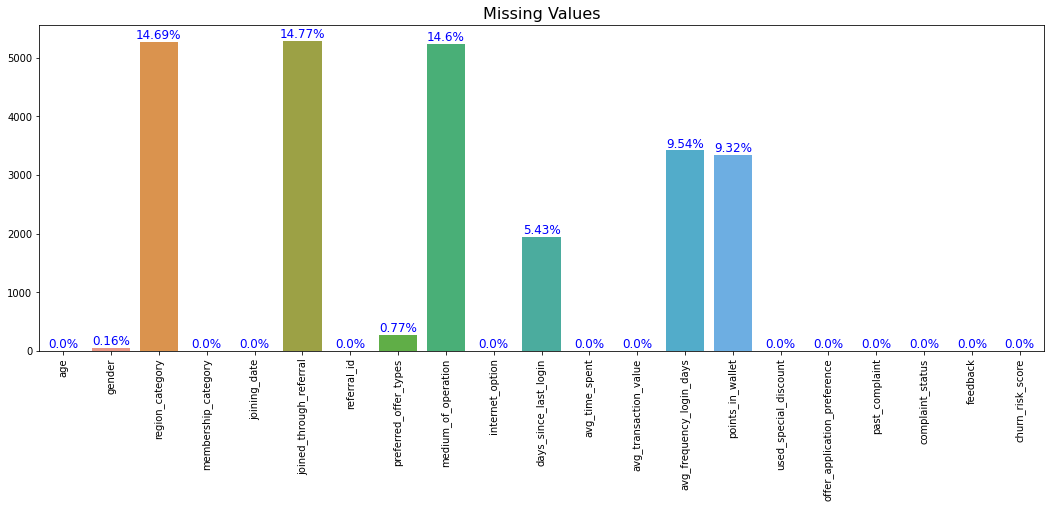

In [16]:
#checking missing value
plt.figure(figsize=(18,6))
g = sns.barplot(x=df.columns, y=df.isna().sum())
plt.xticks(rotation=90)
plt.title('Missing Values', size=16)
for bar in g.patches:
  value = bar.get_height()
  persentase= round((value/len(df))*100,2)

  text=f"{persentase}%"
  textX=bar.get_x()+ bar.get_width()/2
  textY=bar.get_y() + value

  g.text(textX, textY, text, ha='center', va='bottom', color='b', size=12)

plt.show()

In [17]:
#Handling Missing Value
#replace Mising Value in joined_through_referral from referral_id
df['joined_through_referral']=df['referral_id'].apply(lambda x:'No' if x=='xxxxxxxx' else 'Yes')

dfmissing = pd.Series(df.isna().sum().sort_values(ascending=False))
dfmissing = dfmissing[dfmissing != 0]

#replace Missing value numerical feature with median value and categorical feature with most value
for col in dfmissing.index:
  if df[col].dtype == 'object':             #categorical
    df[col] = df[col].fillna(df[col].mode()[0])
  else:                                     #mumerical
    df[col] = df[col].fillna(df[col].median())

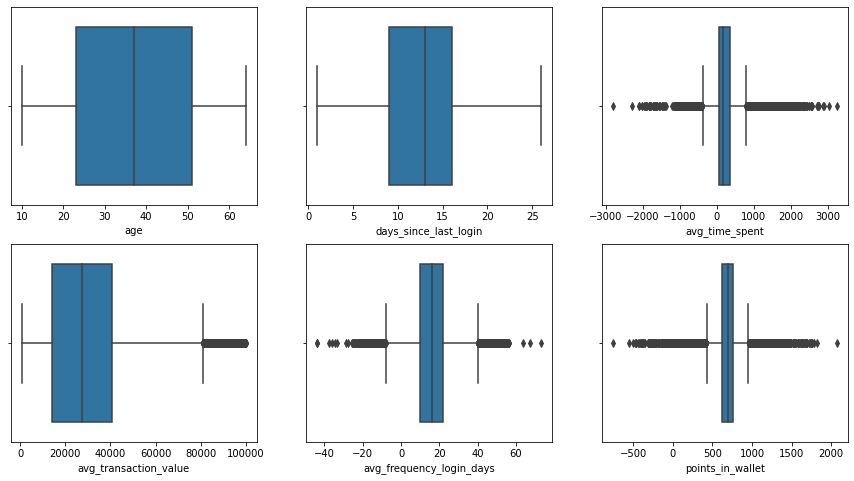

In [18]:
#Checking Outlier
a=1
plt.figure(figsize=(15,8))
for i in num:
    plt.subplot(2,3,a)
    sns.boxplot(df[i])
    a+=1

In [19]:
#Handling Outlier:
#replace the outlier value that is under the lower bound with lower bound value 
# and the outlier value that is top the upper bound with upper bound value
for i in num:
    q1=round(np.percentile(df[i],25),2)
    q3=round(np.percentile(df[i],75),2)
    iqr=q3-q1
    lb=q1-1.5*iqr
    ub=q3+1.5*iqr
    df.loc[df[i] < lb, i] = lb
    df.loc[df[i] > ub, i] = ub

In [20]:
#replace  negative value in feature 'avg frequency login days','avg time spent' to 0
for i in ['avg_frequency_login_days','avg_time_spent' ]:
    df.loc[df[i] < 0, i] = 0

#create fitur joined days from 16 Mar 2021 reduced days since last login then find the difference joining date
#16 Mar 2021 is the date dataset published in Hacker Earth
df['joined_days'] = df['joining_date'].apply(lambda x: int(str(pd.to_datetime('2021-03-16',format='%Y-%m-%d')-x).split()[0]))-df['days_since_last_login']

#drop useless fitur      
df.drop(labels=['referral_id','joining_date','days_since_last_login','complaint_status'],axis=1,inplace=True)

#classify age features
df['age']=df['age'].apply(lambda x: 'Adult' if x>21 else 'Teen')

#classify avg_transaction_value featur
df['avg_transaction_value']=df['avg_transaction_value'].apply(lambda x: 'High' if x>5000 else 'Low')

#label encoding membership_category feature
df['membership_category'] = df['membership_category'].map({'No Membership':0,
                                                           'Basic Membership':1,
                                                           'Silver Membership':2,
                                                           'Gold Membership':3,
                                                           'Premium Membership':4,
                                                           'Platinum Membership':5 })

#label encoding membership_category feature
df['feedback'] = df['feedback'].map({'Products always in Stock':1,
                                     'Quality Customer Care':1,
                                     'Poor Website':-1,
                                     'No reason specified':0,
                                     'Poor Product Quality':-1,
                                     'Poor Customer Service':-1, 
                                     'Too many ads':-1,
                                     'User Friendly Website':1,
                                     'Reasonable Price':1})

#onehot encoding other categorical feature
dfModel= pd.get_dummies(df, columns = ['age',
                                       'avg_transaction_value',
                                       'gender',
                                       'region_category',
                                       'internet_option',
                                       'medium_of_operation',
                                       'preferred_offer_types',
                                       'joined_through_referral',
                                       'used_special_discount',
                                       'offer_application_preference',
                                       'past_complaint'])



#medium_of_operation_Both this means costumer use desktop and smatphone so we replace 0 with 1
dfModel.loc[dfModel['medium_of_operation_Both'] == 1, ['medium_of_operation_Desktop','medium_of_operation_Smartphone']] = 1
#drop medium_of_operation_Both and preferred_offer_types_Without Offers feature
dfModel.drop(labels=['medium_of_operation_Both','preferred_offer_types_Without Offers'],axis=1,inplace=True)
dfModel

#scaler
scaler = RobustScaler()
dfModel.iloc[:,[0,1,2,3,6]] = scaler.fit_transform(dfModel.iloc[:,[0,1,2,3,6]])


#define X an Y for models
X = dfModel.drop(columns = ['churn_risk_score'])
y = dfModel['churn_risk_score']

#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

#handling imbalance data train
oversampler = SMOTE()
X_train,y_train = oversampler.fit_resample(X_train,y_train)

# Develop Model

Akurasi model KNN 64.72 %
Report Metrics KNN 
               precision    recall  f1-score   support

         1.0       0.51      0.61      0.55       551
         2.0       0.46      0.53      0.49       523
         3.0       0.81      0.78      0.80      2107
         4.0       0.55      0.47      0.51      2012
         5.0       0.66      0.73      0.69      1973

    accuracy                           0.65      7166
   macro avg       0.60      0.62      0.61      7166
weighted avg       0.65      0.65      0.65      7166

Confuction Matrix KNN 


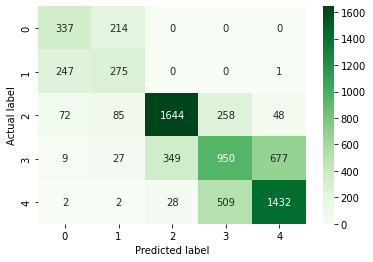

In [21]:
#KNN
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=19)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
akurasiKNN = accuracy_score(y_test, y_pred)
print('Akurasi model KNN', "{:.2f}".format(akurasiKNN * 100),'%')
print(f"Report Metrics KNN \n {classification_report(y_test, y_pred)}")

print(f"Confuction Matrix KNN ")
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, ax = ax, fmt = 'g', cmap='Greens')
ax.set_xlabel('Predicted label')
ax.set_ylabel('Actual label')
plt.show()

Akurasi model Dec Tree 77.56 %
Report Metrics Decesion Tree 
               precision    recall  f1-score   support

         1.0       0.72      0.78      0.75       551
         2.0       0.75      0.69      0.72       523
         3.0       0.90      0.93      0.91      2107
         4.0       0.72      0.55      0.63      2012
         5.0       0.71      0.86      0.78      1973

    accuracy                           0.78      7166
   macro avg       0.76      0.76      0.76      7166
weighted avg       0.78      0.78      0.77      7166

Confuction Matrix Decesion Tree


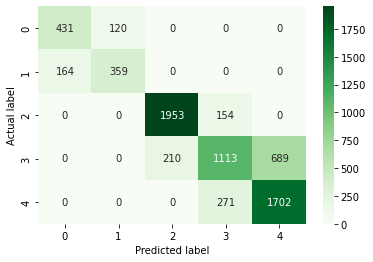

In [22]:
#Decision Tree
dtree = DecisionTreeClassifier(max_depth=15, min_samples_split=10, min_samples_leaf=12)
dtree.fit(X_train, y_train)
y_predDT = dtree.predict(X_test)
akurasiDt = accuracy_score(y_test, y_predDT)
print('Akurasi model Dec Tree', "{:.2f}".format(akurasiDt * 100),'%')
pred = pd.DataFrame(y_predDT, columns=['predict'])
print(f"Report Metrics Decesion Tree \n {classification_report(y_test, y_predDT)}")

print(f"Confuction Matrix Decesion Tree")
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, y_predDT), annot=True, ax = ax, fmt = 'g', cmap='Greens')
ax.set_xlabel('Predicted label')
ax.set_ylabel('Actual label')
plt.show()

Akurasi model Random Forest 78.34 %
Report Metrics Random Forest 
               precision    recall  f1-score   support

         1.0       0.76      0.77      0.76       551
         2.0       0.75      0.74      0.75       523
         3.0       0.89      0.94      0.91      2107
         4.0       0.75      0.54      0.63      2012
         5.0       0.72      0.88      0.79      1973

    accuracy                           0.78      7166
   macro avg       0.77      0.77      0.77      7166
weighted avg       0.78      0.78      0.78      7166

Confuction Matrix Random Forest


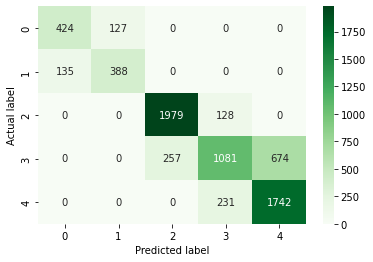

In [23]:
#Random Forest
clf = RandomForestClassifier(n_estimators = 185) 
clf.fit(X_train, y_train)

y_predRF = clf.predict(X_test)
akurasiRF = accuracy_score(y_test, y_predRF)
print('Akurasi model Random Forest', "{:.2f}".format(akurasiRF * 100),'%')
pred = pd.DataFrame(y_predRF, columns=['predict'])
print(f"Report Metrics Random Forest \n {classification_report(y_test, y_predRF)}")

print(f"Confuction Matrix Random Forest")
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, y_predRF), annot=True, ax = ax, fmt = 'g', cmap='Greens')
ax.set_xlabel('Predicted label')
ax.set_ylabel('Actual label')
plt.show()

Akurasi model SVM 66.76 %
Report Metrics SVM 
               precision    recall  f1-score   support

         1.0       0.65      0.69      0.67       551
         2.0       0.65      0.61      0.63       523
         3.0       0.77      0.76      0.77      2107
         4.0       0.50      0.39      0.44      2012
         5.0       0.70      0.85      0.77      1973

    accuracy                           0.67      7166
   macro avg       0.65      0.66      0.65      7166
weighted avg       0.66      0.67      0.66      7166

Confuction Matrix SVM 


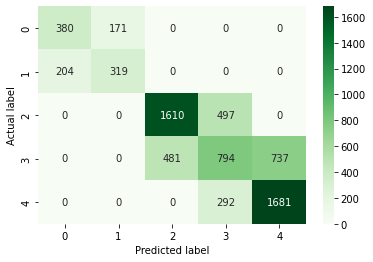

In [24]:
#SVM
model_svm = SVC(kernel='linear')
model_svm.fit(X_train, y_train)
y_predict = model_svm.predict(X_test)
akurasiSVM = accuracy_score(y_test, y_predict)
print('Akurasi model SVM', "{:.2f}".format(akurasiSVM * 100),'%')
print(f"Report Metrics SVM \n {classification_report(y_test, y_predict)}")

print(f"Confuction Matrix SVM ")
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, y_predict), annot=True, ax = ax, fmt = 'g', cmap='Greens')
ax.set_xlabel('Predicted label')
ax.set_ylabel('Actual label')
plt.show()

Akurasi model xgb 77.95 %
Report Metrics xgb 
               precision    recall  f1-score   support

         1.0       0.75      0.76      0.76       551
         2.0       0.74      0.73      0.74       523
         3.0       0.92      0.92      0.92      2107
         4.0       0.70      0.62      0.66      2012
         5.0       0.73      0.81      0.77      1973

    accuracy                           0.78      7166
   macro avg       0.77      0.77      0.77      7166
weighted avg       0.78      0.78      0.78      7166

Confuction Matrix xgb 


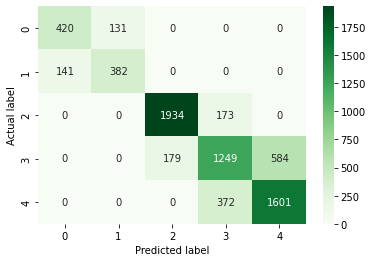

In [25]:
#XGBoost
xgb = XGBClassifier(n_jobs=-1,n_estimators=1000,max_depth=10)
xgb.fit(X_train,y_train)
y_predxgb = xgb.predict(X_test)
akurasixgb = accuracy_score(y_test, y_predxgb)
print('Akurasi model xgb', "{:.2f}".format(akurasixgb * 100),'%')
print(f"Report Metrics xgb \n {classification_report(y_test, y_predxgb)}")

print(f"Confuction Matrix xgb ")
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, y_predxgb), annot=True, ax = ax, fmt = 'g', cmap='Greens')
ax.set_xlabel('Predicted label')
ax.set_ylabel('Actual label')
plt.show()

# Conclusion

* Insights for business can improve service to customers without membership and basic membership to reduce churn rate in business
* for the model we recommend using Random forest or XGBoost because based on the f1-score has the highest value compared to other models with a value of 78%. From the confession metric, the actual churn risk score '1' data is predicted with the model without being mistaken for a churn risk score of '3' ,'4', or '5', there is only an error to churn risk score '2' because the characteristics are almost the same, so it can be be accepted